<a href="https://colab.research.google.com/github/rinivarg/ReproRehab2024-Pod3/blob/main/Materials/Week%204/Week%204%20-%20Codebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5: Statistics
In Week 4, we used visualization to 'analyze' our data. While visualizing data is often the first step in analysis, it only allows us to eyeball patterns and relationships. This week, we move beyond visual inspection to statistical analysis. Statistics allow us to perform two main types of analysis: <br>
1) **_Describe_** what we observed in our data, and
2) **_Infer_** what our data tells us about the broader population<br><br>
    <div style="float: center; margin-center: 5px;">
        <img src="./imgs/descriptive-inferential-statistics.png" alt="Descriptive vs Inferential Statistics - Courtesy of Numiko" width="525" height="275">
        <br>
        <div style="text-align: right;"><small>Adapted from <a href="https://numiqo.com/tutorial/descriptive-inferential-statistics" target="_blank">Numiko</a></small></div>
    </div>

Today we'll learn to conduct these statistical analyses in R. This lesson will cover:

1) Build summary tables and figures for our dataset using `dplyr`,`tidyr`, and `ggplot2`
2) Run basic statistical tests (t-tests, ANOVA, correlations) and interpret output
3) Fit linear models with `lm()` and interpret coefficients
4) Estimate marginal means using `emmeans` and run pairwise comparisons


## Clean the entire workspace

In [1]:
rm(list=ls())

## Load required libraries

In [3]:
ReqdLibs = c("readxl","dplyr","tidyr","gt","sjPlot",
             "ggplot2","ggthemes","ggpubr","ggExtra",
             "lme4","emmeans","janitor","broom","car","IRdisplay")
invisible(lapply(ReqdLibs, library, character.only = TRUE))


## Theme defaults

In [4]:
thm = theme(
          strip.text.x=element_text(size=20,face="bold"),
          strip.text.y=element_text(size=20,face="bold"),
          legend.text=element_text(size=16,face="bold"),
          legend.position = "top",
          legend.title=element_text(size=16,face="bold"),
          title =element_text(size=14, face='bold'),
          text = element_text(colour = "black",size=18), 
          plot.title = element_text(colour = "black",size = 22, face = "bold"),
          axis.ticks.length = unit(0.3,"cm"),
          axis.line = element_line(colour = "black",linewidth=0.85),
          axis.ticks = element_line(colour = "black",linewidth=0.85),
          axis.text = element_text(colour = "black",size=24),
          axis.title=element_text(size=25))

## 1. Summarize our sample in tables and figures

### Read data

In [5]:
# Read in demographics data
demo <- read_excel("SubjectInfo.xlsx")

# Display structure of demo data
head(demo)

Subject No,Age,Reported Weight (kg),Reported Length (cm),Gender,Level Slow,Level Walk,Weight from force plates(kg)
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Sub1,26,86,185,M,885.5529,891.5307,90.57511
Sub2,28,77,178,F,767.7686,760.2377,77.88004
Sub3,21,52,170,M,530.6408,558.2018,55.49656
Sub4,25,73,168,M,NA,NA,NA
Sub5,34,86,173,M,878.6303,898.5188,90.57845
Sub6,19,54,160,F,553.4936,558.2845,56.66555


### Clean up variable names in the demo table

In [6]:
demo_clean = clean_names(demo) %>% filter(subject_no!="Sub4")
head(demo_clean)

subject_no,age,reported_weight_kg,reported_length_cm,gender,level_slow,level_walk,weight_from_force_plates_kg
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Sub1,26,86,185,M,885.5529,891.5307,90.57511
Sub2,28,77,178,F,767.7686,760.2377,77.88004
Sub3,21,52,170,M,530.6408,558.2018,55.49656
Sub5,34,86,173,M,878.6303,898.5188,90.57845
Sub6,19,54,160,F,553.4936,558.2845,56.66555
Sub7,21,59,163,F,605.0228,605.9027,61.71893


### Let's try and reproduce what the authors told us about the sample
<div style="float: center; margin-center: 5px;">
        <img src="./imgs/demo-summ2.png" alt="demo from paper" width="600" height="150">
        <br>
</div>

In [11]:
# Create summary statistics
demo_summary <- demo_clean %>%
  summarise(
    sex = paste0(sum(gender == "M", na.rm = TRUE), "M, ", 
                 sum(gender == "F", na.rm = TRUE), "F"),
    age =    paste0(round(mean(age, na.rm = TRUE),0), " ± ",
                    round(sd(age, na.rm = TRUE),0)),

    # weight = paste0(round(mean(reported_weight_kg, na.rm = TRUE),0), " ± ",
    #                 round(sd(reported_weight_kg, na.rm = TRUE),0)),

    weight = paste0(round(mean(weight_from_force_plates_kg, na.rm = TRUE),0), " ± ",
                    round(sd(weight_from_force_plates_kg, na.rm = TRUE),0)),
                    
    height = paste0(round(mean(reported_length_cm, na.rm = TRUE),0), " ± ",
                    round(sd(reported_length_cm, na.rm = TRUE),0)),
  )
demo_summary
#Create gt table
tb <- demo_summary %>%
  gt()

# # Display inline
tb %>%
  as_raw_html() %>%
  display_html()

# # display_markdown("#### We were able to reproduce means and SD! We also found out that the weight summary was actually from force plate data.")


sex,age,weight,height
<chr>,<chr>,<chr>,<chr>
"6M, 6F",24 ± 5,70 ± 12,173 ± 8


<table class="gt_table" data-quarto-disable-processing="false" data-quarto-bootstrap="false" style="-webkit-font-smoothing: antialiased; -moz-osx-font-smoothing: grayscale; font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji'; display: table; border-collapse: collapse; line-height: normal; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;" bgcolor="#FFFFFF">
 
 
 <th class="gt_col_heading gt_columns_bottom_border gt_left" rowspan="1" colspan="1" scope="col" id="sex" style="border-style: none; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 6px; padding-left: 5px; padding-right: 5px; overflow-x: hidden; text-align: left;" bgcolor="#FFFFFF" valign="bottom" align="left">sex 
 <th class="gt_col_heading gt_columns_bottom_border gt_left" rowspan="1" colspan="1" scope="col" id="age" style="border-style: none; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 6px; padding-left: 5px; padding-right: 5px; overflow-x: hidden; text-align: left;" bgcolor="#FFFFFF" valign="bottom" align="left">age 
 <th class="gt_col_heading gt_columns_bottom_border gt_left" rowspan="1" colspan="1" scope="col" id="weight" style="border-style: none; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 6px; padding-left: 5px; padding-right: 5px; overflow-x: hidden; text-align: left;" bgcolor="#FFFFFF" valign="bottom" align="left">weight 
 <th class="gt_col_heading gt_columns_bottom_border gt_left" rowspan="1" colspan="1" scope="col" id="height" style="border-style: none; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 6px; padding-left: 5px; padding-right: 5px; overflow-x: hidden; text-align: left;" bgcolor="#FFFFFF" valign="bottom" align="left">height 
 
 
 
 6M, 6F 
 24 ± 5 
 70 ± 12 
 173 ± 8

### Let's look at histrograms for level-slow and level-walk

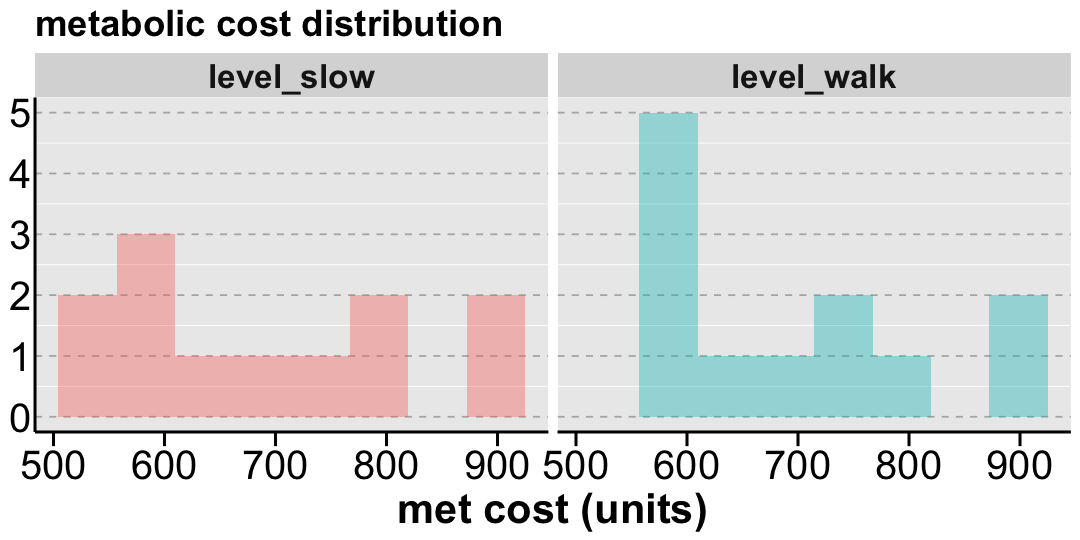

In [12]:
options(repr.plot.width = 9, repr.plot.height = 4.5)

# just for plotting, let's pivot the level_slow and level_walk to look at their distributions together
demo_hist = demo_clean %>% pivot_longer(cols = c(level_slow, level_walk), names_to = "MetCost_cond",values_to = "MetCost_val")

# visualize distributions using geom_histogram
ggplot(data = demo_hist, aes(x = MetCost_val, y = after_stat(count), fill = MetCost_cond)) + 
 geom_histogram(bins = 8,alpha = 0.4, show.legend = FALSE) + 
 labs(title = "metabolic cost distribution", x = "met cost (units)") +
 facet_grid(~MetCost_cond) + 
 theme_cleveland() + thm


## 2. Run basic statistical tests
So you recall the figure we reproduced in Week 4. Let's try to run some basic comparisons using these data.
<div style="float: center; margin-center: 5px;">
        <img src="./imgs/reproduced_figure.svg" alt="demo from paper" width="800" height="200">
        <br>
</div>

In [13]:
# Read in calculated dataset
data_calc <- read.csv("calcData.csv")
# data_calc = data_calc %>% filter(Sub!="Sub4")
head(data_calc)

,Sub,cond,incline,speed,R,VT,VE,VO2,age,reported_weight_kg,reported_length_cm,gender,level_slow,level_walk,weight_from_force_plates_kg,adjVO2,W,W_rest,W_adj,C_meas
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Sub1,walk,downhill,0.8,0.9019424,0.7859465,20.33910,728.5032,26,86,185,M,885.5529,891.5307,90.57511,8.470967,2.920638,1.362433,1.558204,1.947756
2,Sub1,walk,downhill,1.3,0.8661119,0.8409442,25.83893,1005.2468,26,86,185,M,885.5529,891.5307,90.57511,11.688916,3.998645,1.362433,2.636212,2.027855
3,Sub1,walk,level,1.3,0.8340541,1.0104406,32.61279,1368.0726,26,86,185,M,885.5529,891.5307,90.57511,15.907821,5.403549,1.362433,4.041116,3.108550
4,Sub1,walk,uphill,0.8,0.8661413,1.2505480,40.73454,1687.3811,26,86,185,M,885.5529,891.5307,90.57511,19.620710,6.712065,1.362433,5.349632,6.687040
5,Sub1,walk,uphill,1.3,0.8315770,1.4630620,58.84244,2540.5691,26,86,185,M,885.5529,891.5307,90.57511,29.541501,10.029119,1.362433,8.666686,6.666682
6,Sub1,walk,level,0.8,0.8727268,1.0036957,26.00091,992.9288,26,86,185,M,885.5529,891.5307,90.57511,11.545684,3.955388,1.362433,2.592955,3.241194


### Paired T-Tests
Now, you can see that this really is a 3x2 repeated measures design (3 inclines and 2 speeds) but let's begin by running a simple paired t-test to compare the measured metabolic cost between the fast and slow speeds. And then interpret the output. 

In [14]:
# first make sure there in fact are complete paired observations
table(data_calc$speed)

# See the data structure
data_calc %>% count(Sub, speed)


0.8 1.3 
 36  35 

Sub,speed,n
<chr>,<dbl>,<int>
Sub1,0.8,3
Sub1,1.3,3
Sub10,0.8,3
Sub10,1.3,3
Sub11,0.8,3
Sub11,1.3,3
Sub12,0.8,3
Sub12,1.3,2
Sub13,0.8,3


In [16]:
# remove non-complete cases
data_calc2 = data_calc %>% filter(Sub!="Sub12")

# Compare C_meas between speeds 0.8 and 1.3
slow_speed <- data_calc2 %>% filter(speed == 0.8) %>% pull(C_meas)
fast_speed <- data_calc2 %>% filter(speed == 1.3) %>% pull(C_meas)

slow_speed
fast_speed
# Paired t-test
result <- t.test(slow_speed, fast_speed, paired = TRUE)
result


[1] 1.947756 6.687040 3.241194 3.082920 6.421530 2.327802 3.657851 4.728580
 [9] 7.270090 2.337769 3.675276 6.891055 1.790366 3.304059 6.151389 3.405149
[17] 2.477279 6.440500 1.731168 5.971832 3.486698 1.418369 3.365031 5.845703
[25] 2.176668 3.410292 5.888349 2.709213 3.960136 6.671923 1.778972 2.648203
[33] 3.652241

[1] 2.027855 3.108550 6.666682 2.105579 3.154017 5.868374 4.222995 2.527925
 [9] 6.479229 3.423637 2.145940 6.477555 1.474433 6.170071 3.279448 2.119838
[17] 3.525764 6.622940 1.854277 5.855973 3.118922 2.027419 3.189215 5.955852
[25] 1.899880 2.997653 6.183937 1.954473 3.491071 6.527110 3.077266 3.639515
[33] 5.416203


	Paired t-test

data:  slow_speed and fast_speed
t = 0.20974, df = 32, p-value = 0.8352
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.5181596  0.6371173
sample estimates:
mean difference 
     0.05947885 


### ANOVA

#### Simple ANOVA
Here's a simple one-way ANOVA that treats all observations as *independent*.

In [17]:
simple_anova_model <- aov(C_meas ~ incline, data = data_calc2)
summary(simple_anova_model)

            Df Sum Sq Mean Sq F value Pr(>F)    
incline      2 186.33   93.17   293.2 <2e-16 ***
Residuals   63  20.02    0.32                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

#### Repeated Measures ANOVA
But you and I know that these observations are *NOT independent*. <br>This violates a key assumption of the ANOVA. 
So to account for the repeated measures structure, we change the simple ANOVA by adding an `Error()` term specified as `Error(Sub/incline)` which tells R that incline measurements are nested within subjects and hence not independent.

In [18]:
rm_anova_model <- aov(C_meas ~ incline + Error(Sub/incline), 
                   data = data_calc2)

summary(rm_anova_model)


Error: Sub
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 10  9.073  0.9073               

Error: Sub:incline
          Df Sum Sq Mean Sq F value   Pr(>F)    
incline    2 186.33   93.17   329.7 4.89e-16 ***
Residuals 20   5.65    0.28                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 33  5.296  0.1605               

### Correlations
We can also examine relationships between continuous variables. Here we test the correlation between adjusted VO2 and metabolic cost using Pearson correlation and visualize it with a scatterplot.

In [23]:
data_calc2 %>% 
 with(cor.test(C_meas, adjVO2, method = "spearman"))


	Spearman's rank correlation rho

data:  C_meas and adjVO2
S = 7708, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8390982 


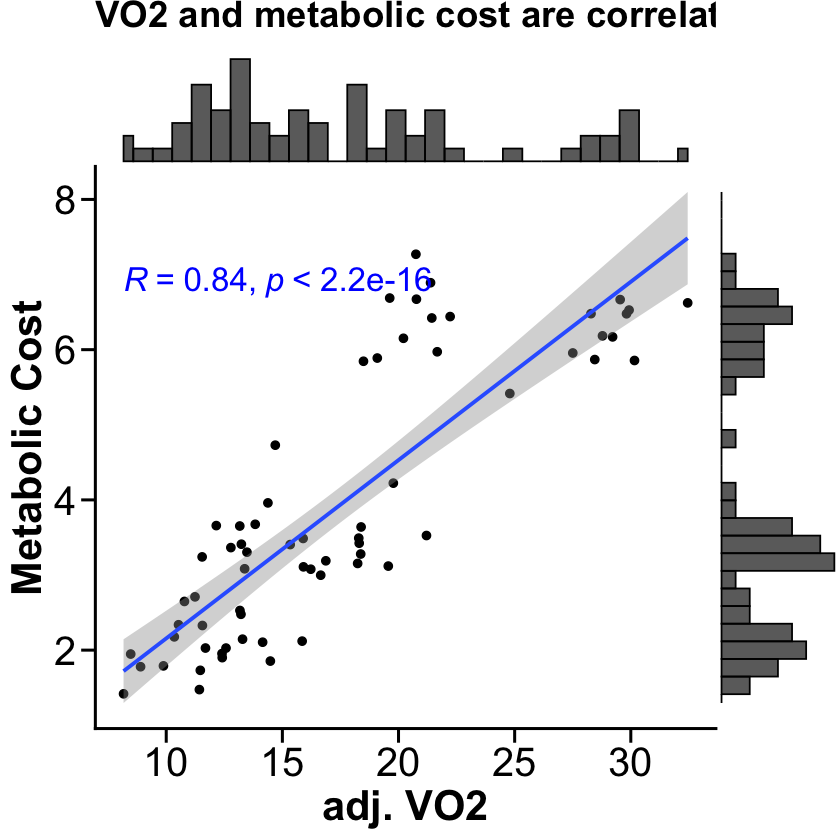

In [24]:
options(repr.plot.width = 7, repr.plot.height = 7)

cor_plot <-

ggplot(data = data_calc2, aes(x = adjVO2,y = C_meas)) + 
 geom_point(size = 2) + geom_smooth(formula = 'y~x',method = "lm") + 
 # the stat_cor function from ggpubr is a neat way to add correlation values on the plot itself
 stat_cor(method = "spearman", size = 7, col = "blue") + 
 labs(title = "VO2 and metabolic cost are correlated", y = "Metabolic Cost", x = "adj. VO2") + 
 theme_classic2() + thm

# cor_plot
ggMarginal(cor_plot, type = "histogram")


## 3. Fit linear models
In this case, because we intend to establish mean differences, fitting a linear model actually is much like running a t-test or ANOVA as we did above. Except it allows us to set interaction terms and do so with missing observations.

In [30]:
lm_fit <- lm(C_meas ~ incline * as.factor(speed), data = data_calc)

summary(lm_fit)
confint(lm_fit)


Call:
lm(formula = C_meas ~ incline * as.factor(speed), data = data_calc)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.54476 -0.24414 -0.05276  0.25556  1.45122 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        2.20663    0.16112  13.696  < 2e-16 ***
inclinelevel                       1.26123    0.22786   5.535 5.99e-07 ***
inclineuphill                      3.99038    0.22786  17.513  < 2e-16 ***
as.factor(speed)1.3               -0.09619    0.23298  -0.413    0.681    
inclinelevel:as.factor(speed)1.3  -0.03100    0.32588  -0.095    0.924    
inclineuphill:as.factor(speed)1.3  0.12202    0.32588   0.374    0.709    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5581 on 65 degrees of freedom
Multiple R-squared:  0.9095,	Adjusted R-squared:  0.9026 
F-statistic: 130.7 on 5 and 65 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
(Intercept),1.8848516,2.5284087
inclinelevel,0.8061620,1.7162893
inclineuphill,3.5353116,4.4454388
as.factor(speed)1.3,-0.5614770,0.3691051
inclinelevel:as.factor(speed)1.3,-0.6818334,0.6198250
inclineuphill:as.factor(speed)1.3,-0.5288127,0.7728457


In [31]:
#ooh, btw, check this out:
display_markdown("#### BTW, if you ran an ANOVA of this linear model, it would give you the exact same estimates as your original ANOVA!")
anova(lm_fit)


#### BTW, if you ran an ANOVA of this linear model, it would give you the exact same estimates as your original ANOVA!

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
incline,2,203.36432749,101.68216375,326.4114629,1.256380e-34
as.factor(speed),1,0.07587859,0.07587859,0.2435790,6.232965e-01
incline:as.factor(speed),2,0.07828560,0.03914280,0.1256529,8.821346e-01
Residuals,65,20.24849430,0.31151530,NA,NA


### Model Diagnostics
1) **Residuals vs Fitted**: Checks if relationship is linear and variance is constant.
    * <span style="color: #9416beff; font-style: italic">We want random scatter around horizontal line at 0.</span>
2) **Q-Q Plot**: Checks if residuals are normally distributed
    * <span style="color: #9416beff; font-style: italic">We want points to follow the diagonal line closely</span>
3) **Scale-Location**: Checks if variance is constant across fitted values (homoscedasticity)
    * <span style="color: #9416beff; font-style: italic">We want horizontal line with random scatter (no systematic shape)</span>
4) **Residuals vs Leverage**: Identifies influential points 
    * <span style="color: #9416beff; font-style: italic">Ideally, we want all points to be within Cook's distance lines</span>

[1] "Influential observation # 13 C Meas is 0.111746052521325" 
[2] "Influential observation # 14 C Meas is 0.0843345595874919"
[3] "Influential observation # 16 C Meas is 0.0610988460034664"
[4] "Influential observation # 70 C Meas is 0.343605624121243" 


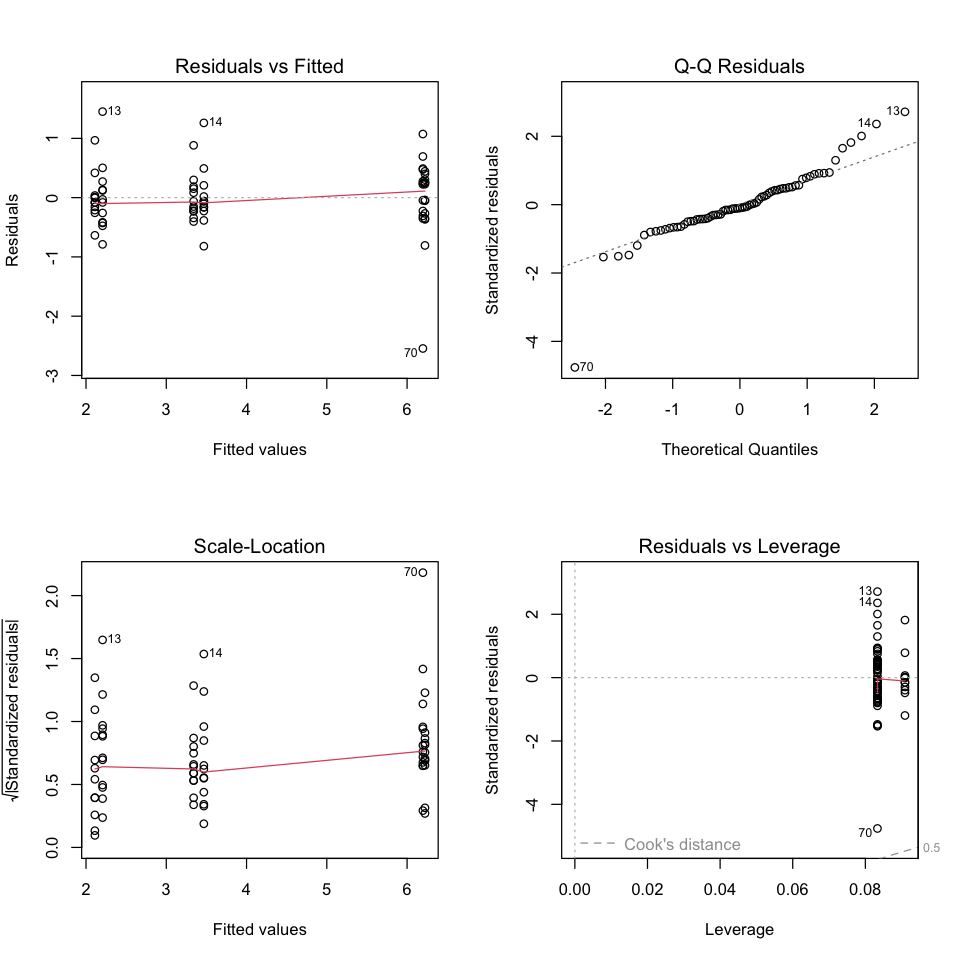

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)

par(mfrow = c(2,2))
plot(lm_fit)

# WE can also print out the exact values and indices of the influential observations
cooksd <- cooks.distance(lm_fit)
influential <- which(cooksd > 4/nrow(data_calc))
print(paste("Influential observation #", influential, "C Meas is", cooksd[influential]))

### Publication-ready regression tables
Here, I am usign the `sjPlot` package to show you an example of a publication-ready regression table. There are many ways/packages to acheive the same type of table, e.g., `gt` and `gtsummary` packages. 

In [32]:
regression_table = tab_model(lm_fit, show.stat = TRUE,
                            dv.labels = "Measured Metabolic Cost")
display_html(regression_table$page.complete)

# saving the table as DOC or HTML
tab_model(lm_fit, file = "linear-model-fit.docx")


Measured Metabolic Cost 
 
 
 Predictors 
 Estimates 
 CI 
 Statistic 
 p 
 
 
 (Intercept) 
 2.21 
 1.88 – 2.53 
 13.70 
 <0.001 
 
 
 incline [level] 
 1.26 
 0.81 – 1.72 
 5.54 
 <0.001 
 
 
 incline [uphill] 
 3.99 
 3.54 – 4.45 
 17.51 
 <0.001 
 
 
 speed [1.3] 
 -0.10 
 -0.56 – 0.37 
 -0.41 
 0.681 
 
 
 incline [level] × speed [1.3] 
 -0.03 
 -0.68 – 0.62 
 -0.10 
 0.924 
 
 
 incline [uphill] × speed [1.3] 
 0.12 
 -0.53 – 0.77 
 0.37 
 0.709 
 
 
 Observations 
 71 
 
 
 R 2 / R 2 adjusted 
 0.910 / 0.903

## 4. Post-hoc pairwise comparisons with marginal means
<center>

|              | **Fast (0.8)** | **Slow (1.3)** | <mark>**Row Mean**</mark> |
|--------------|----------------|----------------|--------------|
| **Downhill** | 2.21           | 2.11           | <mark>2.16</mark> |
| **Level**    | 3.47           | 3.34           | <mark>3.41</mark> |
| **Uphill**   | 6.20           | 6.22           | <mark>6.21</mark> |
| <mark>**Col Mean**</mark> | <mark>**3.96**</mark> | <mark>**3.89**</mark> | <mark>**3.93**</mark> |

</center>

EMMs allow us to follow up significant main effects by testing which specific groups differ from each other, with appropriate corrections for multiple comparisons.


### Estimate marginal means
Note that ours is an interaction model, and we know that the effect of `speed` is not significant. So really we would like marginal means for incline.

NOTE: Results may be misleading due to involvement in interactions



 speed emmean     SE df lower.CL upper.CL
   0.8   3.96 0.0930 65     3.77     4.14
   1.3   3.89 0.0944 65     3.70     4.08

Results are averaged over the levels of: incline 
Confidence level used: 0.95 

------------

NOTE: Results may be misleading due to involvement in interactions



 incline  emmean    SE df lower.CL upper.CL
 downhill   2.16 0.116 65     1.93     2.39
 level      3.40 0.114 65     3.18     3.63
 uphill     6.21 0.114 65     5.98     6.44

Results are averaged over the levels of: speed 
Confidence level used: 0.95 

------------

 speed incline  emmean    SE df lower.CL upper.CL
   0.8 downhill   2.21 0.161 65     1.88     2.53
   1.3 downhill   2.11 0.168 65     1.77     2.45
   0.8 level      3.47 0.161 65     3.15     3.79
   1.3 level      3.34 0.161 65     3.02     3.66
   0.8 uphill     6.20 0.161 65     5.88     6.52
   1.3 uphill     6.22 0.161 65     5.90     6.54

Confidence level used: 0.95 

------------

Some of the focal terms are of type `character`. This may lead to
  unexpected results. It is recommended to convert these variables to
  factors before fitting the model.
  The following variables are of type character: `incline`

Ignoring unknown labels:
• linetype : "speed"
• shape : "speed"


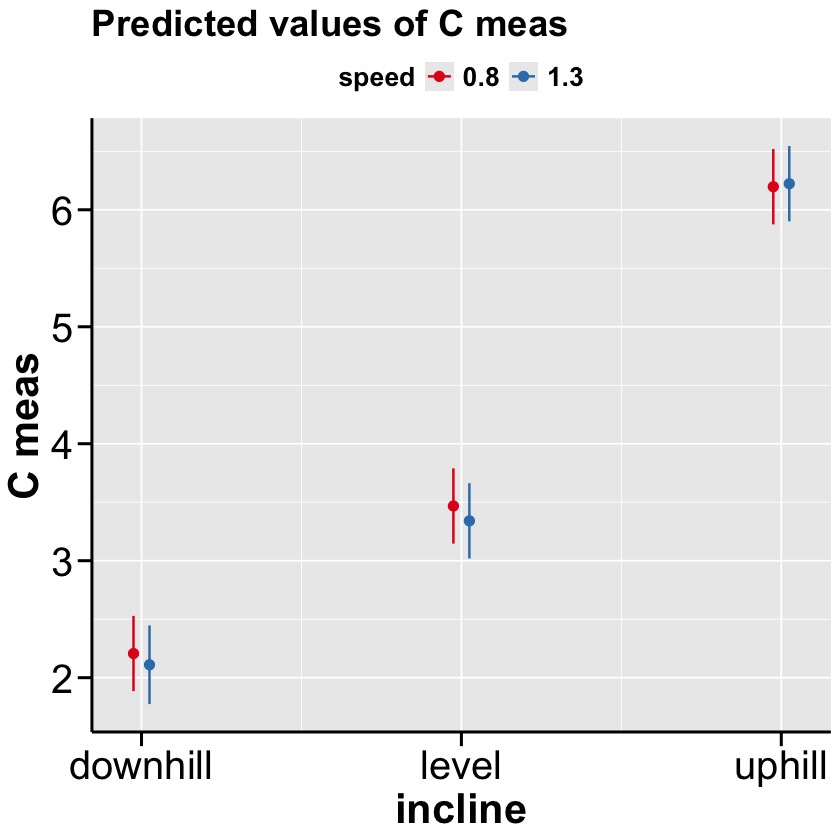

In [48]:
# Estimated marginal means for speed - the same as were compared by the t-test
speed_means <- emmeans(lm_fit, ~ speed)
speed_means

display_markdown("------------")
# Estimated marginal means for incline - the same as were compared by the ANOVA
incline_means <- emmeans(lm_fit, ~ incline)
incline_means

display_markdown("------------")
# Estimated marginal means for both factors - "splits" them by these two factors
speed_by_incline_means <- emmeans(lm_fit, ~ speed + incline)
speed_by_incline_means

display_markdown("------------")
# Plot estimated marginal means
plot_model(lm_fit, type = "pred", terms = c("incline", "speed")) + thm

### Run pairwise comparisons among the various inclines

In [49]:
# With adjustment for multiple comparisons
pairs(incline_means, adjust = "tukey")

display_markdown("------------")
pairs(incline_means, adjust = "bonferroni")

 contrast          estimate    SE df t.ratio p.value
 downhill - level     -1.25 0.163 65  -7.645  <.0001
 downhill - uphill    -4.05 0.163 65 -24.864  <.0001
 level - uphill       -2.81 0.161 65 -17.413  <.0001

Results are averaged over the levels of: speed 
P value adjustment: tukey method for comparing a family of 3 estimates 

------------

 contrast          estimate    SE df t.ratio p.value
 downhill - level     -1.25 0.163 65  -7.645  <.0001
 downhill - uphill    -4.05 0.163 65 -24.864  <.0001
 level - uphill       -2.81 0.161 65 -17.413  <.0001

Results are averaged over the levels of: speed 
P value adjustment: bonferroni method for 3 tests 

### Testing only for hypothesized effects
If you had a hypothesis going in, for example, only uphill will differ from the other two conditions. The other two conditions will not differ from one another, then you can run this comparison by manually specifying contrasts.

In [50]:
# check levels (what comes first, second and third)
factor(data_calc$incline) %>% levels()
# incline_means
contrast(incline_means, 
         list("Uphill - Downhill" = c(-1, 0, 1),    # Compare uphill to downhill
              "Uphill - Level" = c(0, -1, 1)))      # Compare uphill to level

[1] "downhill" "level"    "uphill"

 contrast          estimate    SE df t.ratio p.value
 Uphill - Downhill     4.05 0.163 65  24.864  <.0001
 Uphill - Level        2.81 0.161 65  17.413  <.0001

Results are averaged over the levels of: speed 

# The End